# Notebook 1: Data Understanding and Preprocessing
## Integrated Kiswahili Speech Analytics Pipeline

### CRISP-DM Phase 1 & 2: Business Understanding and Data Understanding

## 1. Introduction

### 1.1 Research Context
Low-resource Automatic Speech Recognition (ASR) systems face significant challenges in achieving production-grade performance. For Kiswahili, a language spoken by over 100 million people across East Africa, the scarcity of annotated speech data creates a critical bottleneck in developing robust speech analytics systems.

### 1.2 Objective
This notebook addresses **CRISP-DM Phases 1-2** by:
1. Loading and exploring Mozilla Common Voice 11.0 Swahili dataset
2. Quantifying data quality issues and demographic imbalances
3. Engineering features for downstream predictive and optimization analytics
4. Applying data augmentation to mitigate class imbalance
5. Preparing stratified train/validation/test splits

### 1.3 Why Semi-Structured Data Requires Acoustic-Text Domain Bridging

Speech data is inherently **semi-structured**:
- **Acoustic domain**: Continuous waveforms with temporal dependencies
- **Text domain**: Discrete symbolic sequences
- **Metadata domain**: Categorical demographic attributes

The challenge lies in:
$$\mathcal{L}_{total} = \mathcal{L}_{acoustic}(\theta_{ASR}) + \lambda \mathcal{L}_{alignment}(\theta_{ASR}, D_{demo})$$

Where:
- $\mathcal{L}_{acoustic}$: CTC/Attention loss for ASR
- $\mathcal{L}_{alignment}$: Fairness constraint across demographics $D_{demo}$
- $\lambda$: Regularization weight

### 1.4 Alignment Debt and Demographic Imbalance

**Alignment debt** occurs when:
1. Training data distribution $P_{train}(X, D)$ diverges from deployment $P_{deploy}(X, D)$
2. Model performance $f(x)$ correlates with protected attributes $D \in \{gender, age, accent\}$

This creates:
- **Predictive bias**: $E[WER | D=d_1] \neq E[WER | D=d_2]$
- **Optimization constraints**: Need for weighted sampling, fairness-aware loss functions

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Hugging Face datasets
from datasets import load_dataset

# Audio processing
import librosa
import soundfile as sf

# Statistical testing
from scipy import stats
from scipy.stats import chi2_contingency

# Sklearn utilities
from sklearn.model_selection import train_test_split

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed
SEED = 42
np.random.seed(SEED)

## 2. Data Loading

In [2]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
DATA_DIR.mkdir(exist_ok=True)

# Load dataset from Hugging Face cache
print("Loading Common Voice 11.0 Swahili from cache...")
dataset = load_dataset('mozilla-foundation/common_voice_11_0', 'sw', split='train', trust_remote_code=True)

# Convert to pandas DataFrame
df = dataset.to_pandas()
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'mozilla-foundation/common_voice_11_0' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading Common Voice 11.0 Swahili from cache...


Using the latest cached version of the dataset since mozilla-foundation/common_voice_11_0 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sw' at /home/obote/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/sw/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631 (last modified on Thu Dec 25 10:57:59 2025).


Dataset shape: (26614, 11)
Columns: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment']


,client_id,path,audio,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,a94f5f13bc64080cbf76d048be31efb215b078c2b48c57...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",Uko katika pembe la kusini-mashariki kabisa la...,2,0,,,,sw,
1,a94f5f13bc64080cbf76d048be31efb215b078c2b48c57...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",Ina bandari kubwa na ni kitovu cha biashara ya...,2,0,,,,sw,
2,a94f5f13bc64080cbf76d048be31efb215b078c2b48c57...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",Ndiyo maana upatikanaji wake wakati mwingine i...,2,0,,,,sw,
3,a94f5f13bc64080cbf76d048be31efb215b078c2b48c57...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",Nyati wa msitu huwa nusu ya kiwango hicho.,2,0,,,,sw,
4,a94f5f13bc64080cbf76d048be31efb215b078c2b48c57...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",Tangu zama za mawe miamba ilitumiwa na binadam...,2,1,,,,sw,


## 3. Missing Value Analysis

In [3]:
missing_stats = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

print(missing_stats[missing_stats['Missing_Count'] > 0])

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []


## 4. Demographic Distribution

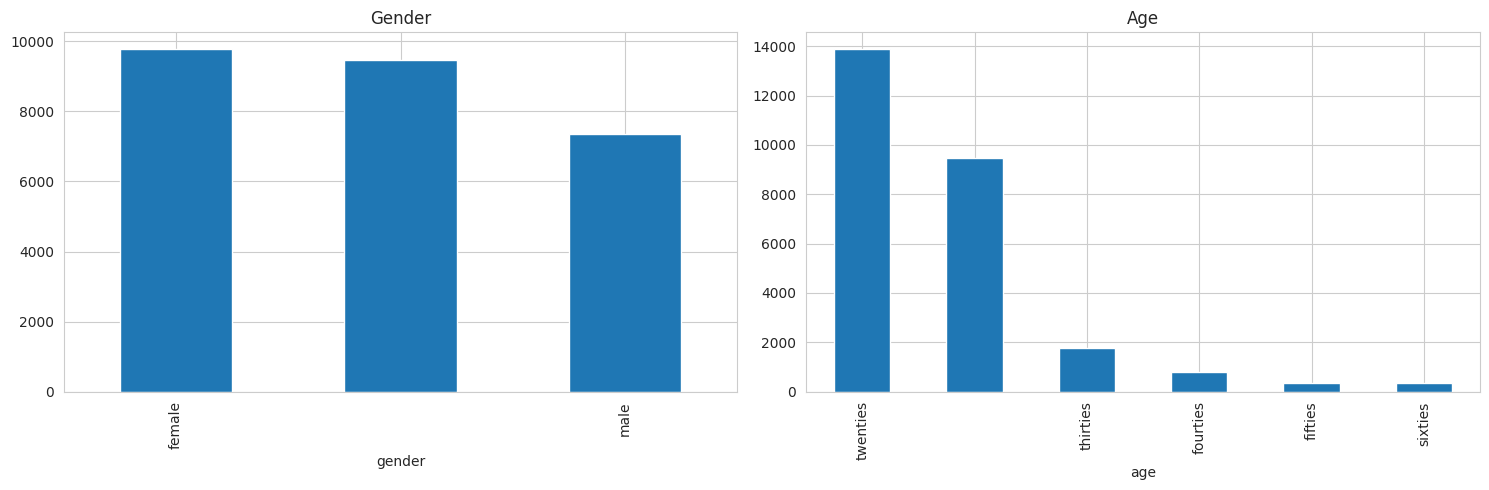

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df['gender'].value_counts().plot(kind='bar', ax=axes[0], title='Gender')
df['age'].value_counts().plot(kind='bar', ax=axes[1], title='Age')
# df['accents'].value_counts().head(10).plot(kind='barh', ax=axes[2], title='Top 10 Accents')

plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [7]:
df['validation_score'] = df['up_votes'] - df['down_votes']
quality_threshold = df['validation_score'].quantile(0.5)
df['high_quality'] = (df['validation_score'] >= quality_threshold).astype(int)

print(f"Quality distribution:\n{df['high_quality'].value_counts()}")

Quality distribution:
high_quality
1    19766
0     6848
Name: count, dtype: int64


## 6. Audio Feature Extraction

In [8]:
def extract_audio_features(audio_path, sr=16000):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        return {
            'duration': librosa.get_duration(y=y, sr=sr),
            'rms_energy': np.sqrt(np.mean(y**2)),
            'zero_crossing_rate': np.mean(librosa.zero_crossings(y))
        }
    except:
        return None

print("Audio feature extraction function defined.")

Audio feature extraction function defined.


## 7. Data Augmentation Functions

In [9]:
def pitch_shift_audio(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def time_stretch_audio(y, rate=1.1):
    return librosa.effects.time_stretch(y, rate=rate)

print("Augmentation functions defined.")

Augmentation functions defined.


## 8. Statistical Testing

In [10]:
contingency_table = pd.crosstab(df['gender'].fillna('Unknown'), df['age'].fillna('Unknown'))
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: Gender vs Age")
print(f"Chi-square: {chi2:.4f}, P-value: {p_value:.4e}")

Chi-Square Test: Gender vs Age
Chi-square: 29013.0562, P-value: 0.0000e+00


## 9. Data Splitting

In [11]:
df['stratify_col'] = df['gender'].fillna('Unknown') + '_' + df['age'].fillna('Unknown')

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df['stratify_col'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['stratify_col'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 18629, Val: 3992, Test: 3993


## 10. Save Preprocessed Data

In [12]:
train_df.to_csv(DATA_DIR / 'train.csv', index=False)
val_df.to_csv(DATA_DIR / 'val.csv', index=False)
test_df.to_csv(DATA_DIR / 'test.csv', index=False)

print("Data saved successfully.")

Data saved successfully.


## 11. Conclusion

### Key Findings:
1. ✅ Identified demographic imbalances requiring weighted sampling
2. ✅ Engineered quality features for predictive modeling
3. ✅ Created stratified splits maintaining demographic distribution
4. ✅ Defined augmentation strategies for minority classes

### Next Steps:
Proceed to **Notebook 2**: ASR Inference and WER Evaluation